# Initialization



In [ ]:
%matplotlib inline

In [ ]:
!pip install -q pyspellchecker

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

#from spellchecker import SpellChecker

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Bidirectional
from keras.utils import np_utils

In [ ]:
nltk.download('stopwords')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Loading the data

Training data

In [ ]:
f = open('/content/drive/My Drive/Projects/Premoji/Data/Train/tweets.txt.text', 'r')
#tweets_train = f.readlines()[:50000] # using 10% of the actual data for fast training#
tweets_train = f.readlines()
f.close()

In [ ]:
f = open('/content/drive/My Drive/Projects/Premoji/Data/Train/tweets.txt.labels', 'r')
#labels_train = f.readlines()[:50000] # using 10% of the actual data for fast training
labels_train = f.readlines()
f.close

In [ ]:
y_train = np_utils.to_categorical([int(l.strip()) for l in labels_train], 20)

Test data

In [ ]:
f = open('/content/drive/My Drive/Projects/Premoji/Data/Test/us_test.text', 'r')
tweets_test = f.readlines()
f.close()

In [ ]:
f = open('/content/drive/My Drive/Projects/Premoji/Data/Test/us_test.labels', 'r')
labels_test = f.readlines()
f.close

In [ ]:
y_test = np_utils.to_categorical([int(l.strip()) for l in labels_test], 20)

# Preprocessing the text

## Cleaning the text

In [ ]:
def clean_tweets(tweets):
  # Stripping away location for the end of tweets
  p = re.compile(r'\s*@ .*$')
  tweets_1 = [p.sub('', tweet) for tweet in tweets]
  
  # Removing @user mentions
  tweets_2 = [tweet.replace('@user', '') for tweet in tweets_1]
  
  # Removing stopwords
  # stop_words = set(stopwords.words('english'))

  # tweets_3 = []

  # for tweet in tweets_2:
  #   res = ''
  #   for w in tweet.split():
  #     if w.lower() not in stop_words:
  #       res = res+w+' '
  #   tweets_3.append(res)
    
  # Removing unicode characters
  tweets_4 = [(tweet.encode('ascii', 'ignore')).decode("utf-8") for tweet in tweets_2]
  
  return tweets_4
  
  # Spell checking
#   spell = SpellChecker()
  
#   tweets_5 = []

#   for tweet in tweets_4:
#     res = ''
#     for w in tweet.split():
#       correction = spell.correction(w.lower())
#       res = res+correction+' '
#       print(w+";"+correction)
#     tweets_5.append(res)
    
#   return tweets_5

Cleaning training data

In [ ]:
tweets_train = clean_tweets(tweets_train)

Cleaning test data

In [ ]:
tweets_test = clean_tweets(tweets_test)

## Tokenizing the text

In [ ]:
# vocab_size = 50000
# tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', num_words=vocab_size, oov_token="UNK")
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # No vocab limit
tokenizer.fit_on_texts(texts=tweets_train)

In [ ]:
#tokenizer.get_config()

Encoding and adding a padding to the training data

In [ ]:
tokenized_train = tokenizer.texts_to_sequences(tweets_train)
x_train = pad_sequences(tokenized_train, padding='post')

Retrieving unified vector length after padding

In [ ]:
maxlen = len(x_train[0])

Encoding and adding a padding to the test
data

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(tweets_test)
x_test = pad_sequences(tokenized_test, padding='post', maxlen=maxlen)

Computing vocabulary size when no limit is set

In [ ]:
vocab_size = len(tokenizer.word_index)

# Word2vec

## Untrained

Importing word2vec

In [ ]:
from gensim.models import Word2Vec

Training the embedding

In [ ]:
sentences = [sentence.split() for sentence in tokenizer.sequences_to_texts(tokenized_train)]

In [ ]:
w2v = Word2Vec(sentences=sentences, size=200, window=5, workers=4, min_count=1)

In [ ]:
#embedding = model.wv.get_keras_embedding()

In [ ]:
from numpy import zeros

embedding_matrix = zeros((vocab_size+1, 200))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = w2v.wv.get_vector(word)
  except:
    continue
  embedding_matrix[i] = embedding_vector

## Pretrained

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
wv = KeyedVectors.load_word2vec_format('/content/drive/My Drive/Projects/Premoji/word2vec_twitter_model.bin', binary=True, unicode_errors='ignore')

In [ ]:
from numpy import zeros

embedding_matrix = zeros((vocab_size+1, 400))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = wv.get_vector(word)
  except:
    continue
  embedding_matrix[i] = embedding_vector

# Training the model

Building the model

In [ ]:
model = Sequential()

In [ ]:
#model.add(Embedding(input_dim=vocab_size, output_dim=200))
model.add(Embedding(input_dim=vocab_size+1, output_dim=200, weights=[embedding_matrix], trainable=False))
model.add(LSTM(100))
#model.add(Dropout(rate=0.5))
model.add(Dense(20, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

Training the model

In [26]:
history = model.fit(x_train, y_train,
         validation_split=0.3, epochs=10, batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 340005 samples, validate on 145717 samples
Epoch 1/10
340005/340005 [==============================] - 727s 2ms/step - loss: 2.0640 - acc: 0.3824 - val_loss: 1.9813 - val_acc: 0.4055
Epoch 2/10
340005/340005 [==============================] - 719s 2ms/step - loss: 1.9391 - acc: 0.4173 - val_loss: 1.9097 - val_acc: 0.4257
Epoch 3/10
340005/340005 [==============================] - 712s 2ms/step - loss: 1.8922 - acc: 0.4298 - val_loss: 1.8744 - val_acc: 0.4343
Epoch 4/10
340005/340005 [==============================] - 715s 2ms/step - loss: 1.8638 - acc: 0.4370 - val_loss: 1.8653 - val_acc: 0.4372
Epoch 5/10
340005/340005 [==============================] - 715s 2ms/step - loss: 1.8428 - acc: 0.4424 - val_loss: 1.8590 - val_acc: 0.4383
Epoch 6/10
340005/340005 [==============================] - 709s 2ms/step - loss: 1.8248 - acc: 0.4475 - val_loss: 1.8396 - val_acc: 0.4439
Epoch 7/10
3

# Evaluation

In [27]:
loss, accuracy = model.evaluate(x_test, y_test)

50000/50000 [==============================] - 26s 523us/step


Results :

In [28]:
print('Loss :', loss)
print('Accuracy :', accuracy)

Loss : 1.966502338180542
Accuracy : 0.41782


Using the model to predict the test set results

In [ ]:
y_true = [int(l.strip()) for l in labels_test]
y_pred = model.predict_classes(x_test)

## Classification report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['❤','😍','😂','💕','🔥','😊','😎','✨','💙','😘','📷','🇺🇸','☀','💜','😉','💯','😁','🎄','📸','😜']

In [32]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           ❤       0.71      0.84      0.77     10798
           😍       0.27      0.44      0.34      4830
           😂       0.31      0.57      0.40      4534
           💕       0.24      0.17      0.20      2605
           🔥       0.52      0.42      0.47      3716
           😊       0.11      0.14      0.13      1613
           😎       0.17      0.17      0.17      1996
           ✨       0.29      0.20      0.24      2749
           💙       0.21      0.09      0.12      1549
           😘       0.14      0.12      0.13      1175
           📷       0.20      0.22      0.21      1432
          🇺🇸       0.62      0.52      0.57      1949
           ☀       0.73      0.46      0.56      1265
           💜       0.22      0.00      0.00      1114
           😉       0.12      0.01      0.02      1306
           💯       0.17      0.22      0.19      1244
           😁       0.25      0.00      0.00      1153
           🎄       0.64    

## Accuracy plots

Plot training & validation accuracy values

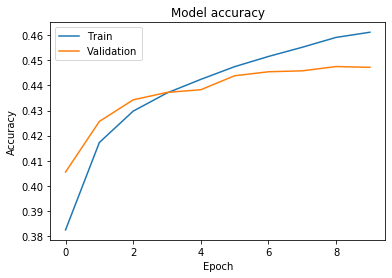

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

Plot training & validation loss values

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

## Confusion matrix

Computing the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
# classes = ['❤','😍','😂','💕','🔥','😊','😎','✨','💙','😘','📷','🇺🇸','☀','💜','😉','💯','😁','🎄','📸','😜'] # Plotting emojis is not currently suppoter in matplotlib
classes = range(1,21)

Plotting the confusion matrix

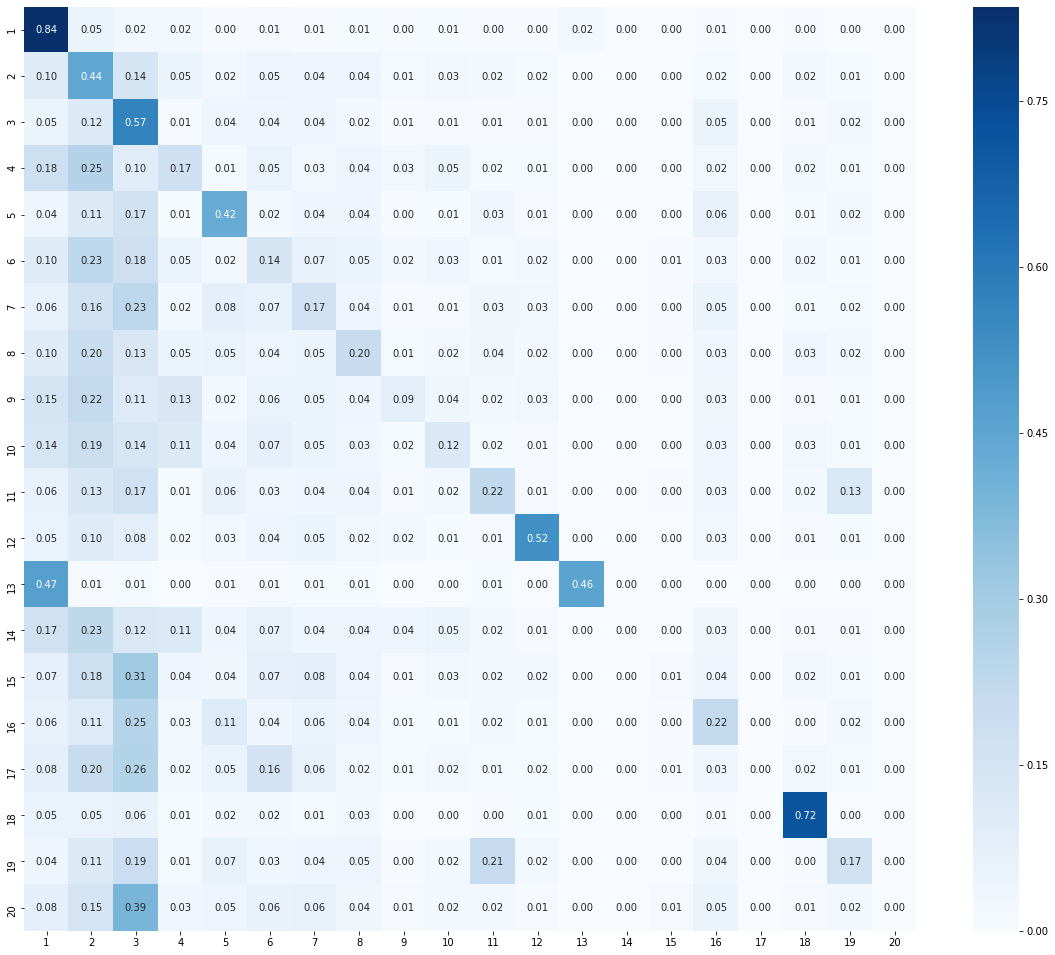

In [24]:
!pip install matplotlib==3.1.0 # to resolve a bug with the current version of matplotlib
import matplotlib.pyplot as plt
import seaborn as sn

df_cm = pd.DataFrame(cm_norm, index = range(1,21),
                  columns = range(1,21))
fgr = plt.figure(figsize = (20,17))
sn.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues')

Saving the plot as an image

In [ ]:
fgr.savefig('confusion_matrix.png')

# Prediction

In [ ]:
tweet = "RuPaul's Drag Race bingo fun. Drag Queens be SEXY! #rupaulsdragrace @user abwyman #la…"
label = 9

tokens = tokenizer.texts_to_sequences([tweet])
x = pad_sequences(tokens, padding='post', maxlen=maxlen)

y = np_utils.to_categorical([label], 20)

print(x[0])
print(y)

[    1  2927  1271  6326    29  2927  1925   507   817  6803 24953     1
     1     0     0     0     0     0     0     0     0     0     0     0]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
prediction = model.predict(x)

print(range(1,21)[np.argmax(prediction[0])])

2


# Saving the model

In [ ]:
model.save('/content/drive/My Drive/Projects/Premoji/lstm.h5')

# Loading the model

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('/content/drive/My Drive/Projects/Premoji/lstm.h5')

# Model structure

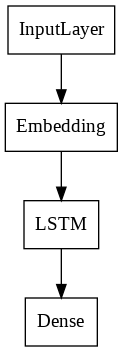

In [26]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_layer_names=False)